In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [4]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_households,population_per_househoulds,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   longitude                   17564 non-null  float32 
 1   latitude                    17564 non-null  float32 
 2   housing_median_age          17564 non-null  int8    
 3   total_rooms                 17564 non-null  int16   
 4   total_bedrooms              17564 non-null  int16   
 5   population                  17564 non-null  int16   
 6   households                  17564 non-null  int16   
 7   median_income               17564 non-null  float32 
 8   median_house_value          17564 non-null  int32   
 9   ocean_proximity             17564 non-null  category
 10  median_income_cat           17564 non-null  int64   
 11  rooms_per_households        17564 non-null  float32 
 12  population_per_househoulds  17564 non-null  float32 
 13  bedrooms_per_roo

In [8]:
#Target
coluna_target = ['median_house_value'] 

#categorias que não tem ordem
coluna_one_hot_encoder = ['ocean_proximity']

#categorias que tem ordem
coluna_ordinal_encoder = ['median_income_cat'] 



In [10]:
#colunas robust scaler
colunas_robust_scaler = df.columns.difference(coluna_one_hot_encoder + coluna_ordinal_encoder + coluna_target)


In [12]:
#criando meu preprocessamento de colunas e features polinomiais

#Criando um pipeline para minhas colunas numericas
pipeline_robust = Pipeline(steps=[
    ('robust_scaler', RobustScaler()), #Primeiro aplico o robust scaler
    ('poly', PolynomialFeatures(degree=1, include_bias=False)) #Em cima desse resultado aplico o Polynomial features
])

#Aplicando o resultado do pipeline anterior scaler a todas as colunas numericas e preprocessamento categórcas
preprocessamento = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder), #O auto auto reconhece as categorias
        ('one_hot_encoder', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler_poly', pipeline_robust, colunas_robust_scaler) #Parecido com o standard, mas menos sensivel a outliers(bom de usar quando minha base tem muitos outliers)
    ],
)



In [14]:
#Separando meu target das features

#Features
X = df.drop(columns=coluna_target)

#Target
y = df[coluna_target]

In [16]:
#Verificando o alpha do Ridge e o grau do Polinomial features

param_grid = {
    'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,2,3], #Testando o grau do polunomial features
    'regressor__reg__alpha': [0.01, 0.02, 0.1, 0.5, 1, 10, 20, 50] #Testando o alpha do Ridge
}

In [18]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid = param_grid   
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
      dtype='object'))])),
                                                                            ('reg',
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.02, 0.1, 0.5, 1, 10,
                                                   20, 50]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [20]:
grid_search.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
      dtype='object'))])),
                                                                            ('reg',
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.02, 0.1, 0.5, 1, 10,
                                                   20, 50]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [22]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10}

In [24]:
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['median_income_cat']),
                                                                                      ('one_hot_encoder',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['ocean_proximity']),
                                                                                      ('robust_scaler_poly',
                                                                                       Pipeline(steps=[('robust_scaler',
                                                                                                        RobustScaler()),
                                                                                                       ('poly',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False))]),
                                                                                       Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population',
       'population_per_househoulds', 'rooms_per_households', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])),
                                                     ('reg', Ridge(alpha=10))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [26]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-1.032656
robust_scaler_poly__latitude,-0.962411
one_hot_encoder__ocean_proximity_INLAND,-0.466702
robust_scaler_poly__latitude longitude population_per_househoulds,-0.414481
robust_scaler_poly__population_per_househoulds,-0.331970
...,...
robust_scaler_poly__bedrooms_per_room housing_median_age total_rooms,0.243656
robust_scaler_poly__housing_median_age median_income,0.246982
robust_scaler_poly__latitude^2 longitude,0.253665
robust_scaler_poly__bedrooms_per_room,0.339457


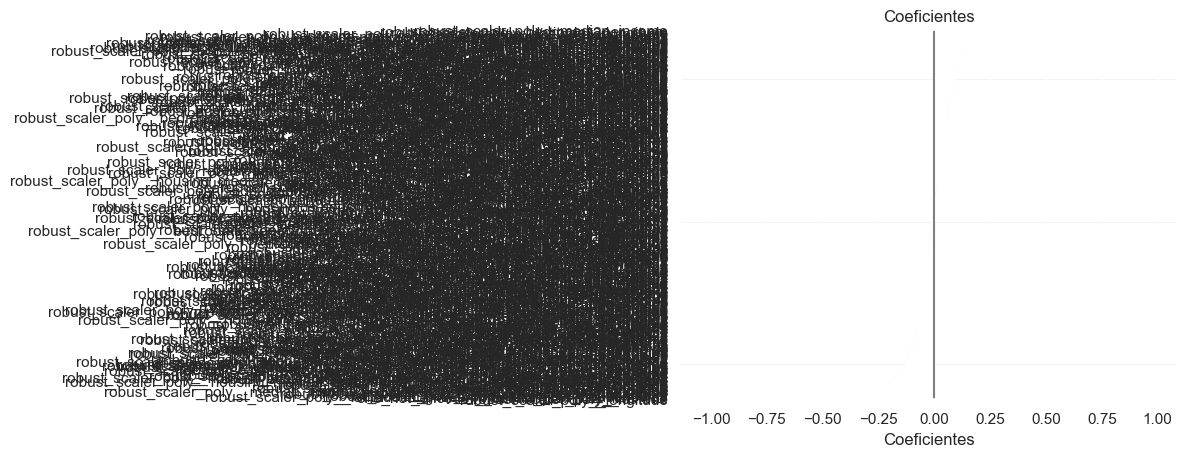

In [28]:
plot_coeficientes(coefs)

In [30]:
#Verificando coeficientes que estão dentro de faixas insignificantes

coefs[coefs['coeficiente'].between(-0.2, 0.2)]

,coeficiente
one_hot_encoder__ocean_proximity_NEAR BAY,-0.199364
robust_scaler_poly__housing_median_age population_per_househoulds total_bedrooms,-0.196156
robust_scaler_poly__longitude median_income,-0.193630
robust_scaler_poly__households median_income^2,-0.184218
robust_scaler_poly__bedrooms_per_room rooms_per_households,-0.179608
...,...
robust_scaler_poly__total_bedrooms,0.169647
robust_scaler_poly__median_income population population_per_househoulds,0.172026
robust_scaler_poly__bedrooms_per_room rooms_per_households total_bedrooms,0.174074
robust_scaler_poly__median_income population rooms_per_households,0.176238


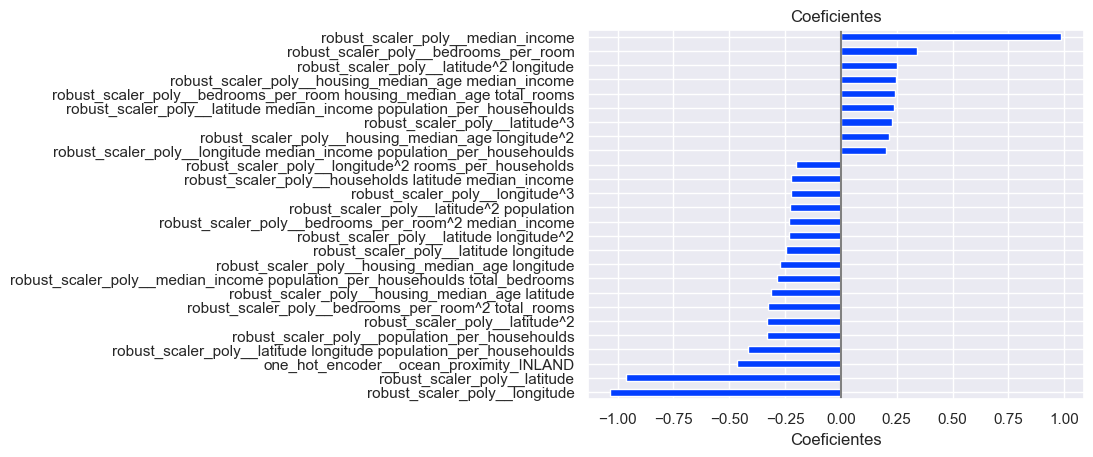

In [32]:
#Criando o gráfico dos coeficientes relevantes
plot_coeficientes(coefs[~coefs['coeficiente'].between(-0.2, 0.2)])

In [34]:
#Comparando os modelos já treinados com meu gridsearch

regressors = {
    #Dummyregressor
    'DummyRegressor' : {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },

    #LinearRegressor sem transformação de target e só com categórcas
     'LinearRegression' : {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },

    
    #LinearRegressor com transformação de target quantile transformer (best param do grid search)
     'Ridge_grid_seach' : {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.003001,0.003015,-0.000081,-77516.042766,-96239.705692,0.006016
1,DummyRegressor,0.001989,0.002995,-0.000146,-75787.787194,-95217.629397,0.004984
2,DummyRegressor,0.003001,0.001998,-0.001737,-76753.598961,-96253.253947,0.004999
3,DummyRegressor,0.001994,0.004998,-0.000101,-76837.804811,-95983.885799,0.006993
4,DummyRegressor,0.001003,0.001998,-0.000114,-76617.245449,-96182.764729,0.003001
5,LinearRegression,0.064999,0.004999,0.682162,-39855.690996,-54254.958188,0.069998
6,LinearRegression,0.017002,0.005005,0.66999,-40272.565467,-54695.230283,0.022007
7,LinearRegression,0.016996,0.007,0.649247,-42178.05929,-56955.988706,0.023997
8,LinearRegression,0.019001,0.005999,0.669873,-40806.492497,-55146.318803,0.025
9,LinearRegression,0.018,0.004999,0.669023,-40788.496497,-55331.35106,0.022999


In [36]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002198,0.003001,-0.000436,-76702.495836,-95975.447913,0.005199
LinearRegression,0.0272,0.005601,0.668059,-40780.26095,-55276.769408,0.0328
Ridge_grid_seach,0.071982,0.013227,0.723194,-35338.945507,-50466.492196,0.085209


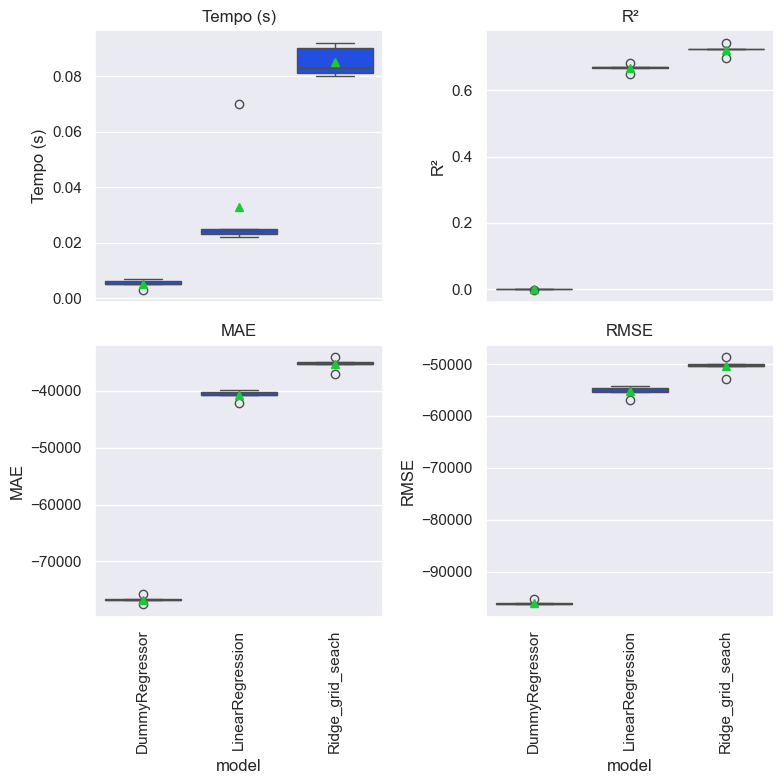

In [38]:
plot_comparar_metricas_modelos(df_resultados)

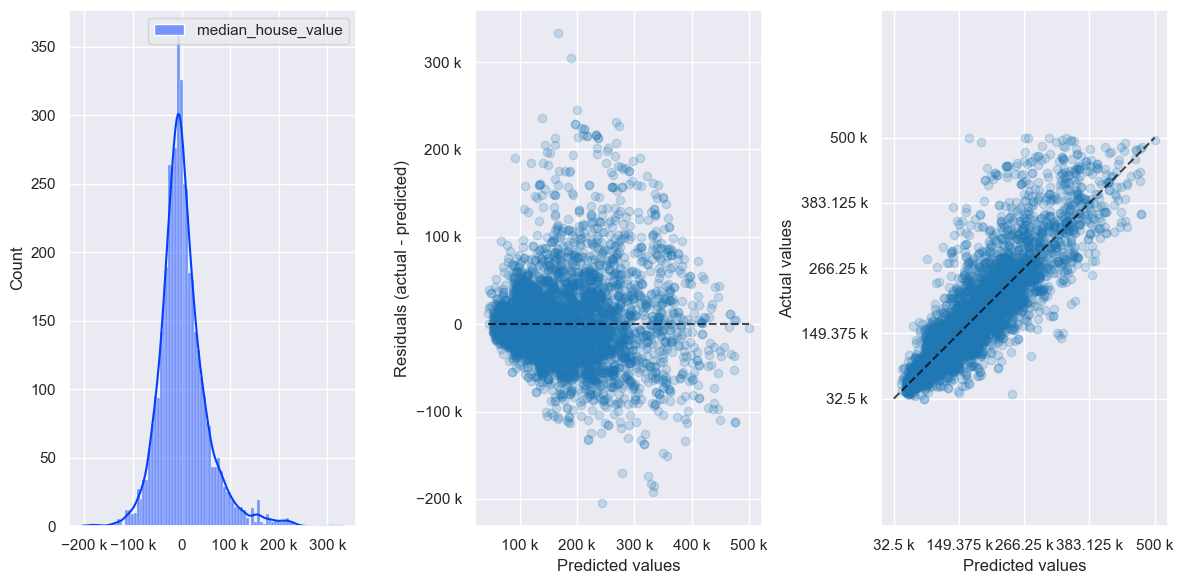

In [40]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, eng_formatter=True)

In [46]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\rafae\\OneDrive\\Cursos\\Hashtag\\Ciencias de dados\\projetos\\05-projeto\\modelos\\ridge_polyfeat_target_quantile.joblib']

AttributeError: module 'streamlit' has no attribute 'hello'